# NUMBER PLATE DETECTION USING CNN MODEL - 25MML0020 

# Data Loading

In [1]:
import zipfile
import os

zip_path = "np.zip"   # name of zip file
extract_path = "number_plates"   # folder to extract into

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed.")


Extraction completed.


# Resizing and Normalizing

In [2]:
from PIL import Image
import numpy as np
import os

data_path = "number_plates/number_plate_images_ocr/number_plate_images_ocr"
images = []
labels = []

for file in os.listdir(data_path):
    path = os.path.join(data_path, file)

    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
        img = Image.open(path).convert("RGB")
        img = img.resize((64, 64))
        img = np.array(img) / 255.0

        images.append(img)
        labels.append(0)

X = np.array(images)
y = np.array(labels)

print("Dataset shape:", X.shape)


Dataset shape: (20, 64, 64, 3)


# Feature Engineering

In [21]:
from PIL import Image, ImageOps
import numpy as np
import os

# reload original image (do not reuse processed img)
data_path = "number_plates/number_plate_images_ocr/number_plate_images_ocr"
files = [f for f in os.listdir(data_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
sample_image = os.path.join(data_path, files[0])

img = Image.open(sample_image)
img = ImageOps.exif_transpose(img)

# check size
print("Image size:", img.size)

# define plate bounding box
box = (1600, 2100, 2400, 2600)

# crop
plate = img.crop(box)

# feature engineering
plate_gray = plate.convert("L")
plate_resized = plate_gray.resize((128, 64))

# convert to numerical array
plate_array = np.array(plate_resized) / 255.0
plate_array = plate_array.reshape(64, 128, 1)

print("Feature shape:", plate_array.shape)
print("Pixel range:", plate_array.min(), plate_array.max())


Image size: (2448, 3264)
Feature shape: (64, 128, 1)
Pixel range: 0.1803921568627451 1.0


# Train - Test  Splitting 

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Applying CNN Model

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(16, (3,3), activation='relu', input_shape=(64,64,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


# Checking Initial Weights

In [24]:
initial_weights = model.get_weights()

print("Initial weight sample:")
print(initial_weights[0].flatten()[:10])


Initial weight sample:
[ 0.06830499  0.15903777  0.02548361  0.06857398  0.14973128 -0.06327369
 -0.12744856  0.01525547  0.01874058  0.0373313 ]


# Training the CNN 

In [25]:
history = model.fit(
    X_train, y_train,
    epochs=5,
    validation_data=(X_test, y_test)
)

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.0000e+00 - loss: 0.7548 - val_accuracy: 1.0000 - val_loss: 0.1726
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 1.0000 - loss: 0.1933 - val_accuracy: 1.0000 - val_loss: 0.0401
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 1.0000 - loss: 0.0484 - val_accuracy: 1.0000 - val_loss: 0.0073
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 1.0000 - loss: 0.0093 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 2.0513e-04


# Checking Accuracy

In [26]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 1.0000 - loss: 2.0513e-04
Test Accuracy: 1.0


# Checking Weights After Training

In [27]:
trained_weights = model.get_weights()

print("Trained weight sample:")
print(trained_weights[0].flatten()[:10])


Trained weight sample:
[ 0.06898198  0.16301426  0.02984631  0.07273139  0.14768825 -0.06661679
 -0.12885414  0.01924129  0.02338473  0.03642932]


# Comparing Weights 

In [28]:
difference = np.mean(
    np.abs(initial_weights[0] - trained_weights[0])
)

print("Average weight change:", difference)


Average weight change: 0.0029178234


# Highlighting the number plate

(np.float64(-0.5), np.float64(2447.5), np.float64(3263.5), np.float64(-0.5))

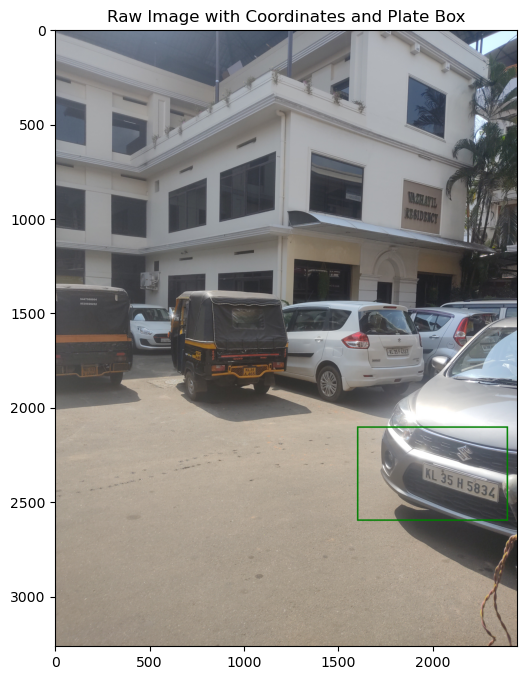

In [29]:
from PIL import Image, ImageOps, ImageDraw
import matplotlib.pyplot as plt
import os

data_path = "number_plates/number_plate_images_ocr/number_plate_images_ocr"

# load a sample image
files = [f for f in os.listdir(data_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
sample_image = os.path.join(data_path, files[0])

img = Image.open(sample_image)
img = ImageOps.exif_transpose(img)

# draw green box
draw = ImageDraw.Draw(img)
box = (1600, 2100, 2400, 2600)
draw.rectangle(box, outline="green", width=8)

# display with coordinates
plt.figure(figsize=(6,8))
plt.imshow(img)
plt.title("Raw Image with Coordinates and Plate Box")
plt.axis("on")  # shows coordinate axes


# Displaying Processed Image after Feature Engineering

(np.float64(-0.5), np.float64(127.5), np.float64(63.5), np.float64(-0.5))

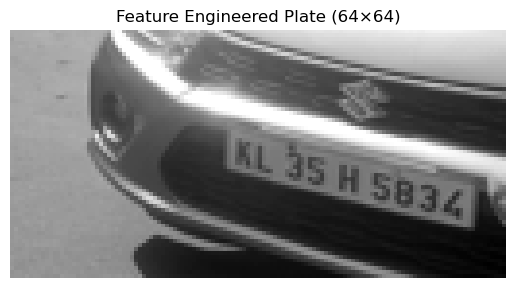

In [30]:
plt.imshow(plate_resized, cmap="gray")
plt.title("Feature Engineered Plate (64×64)")
plt.axis("off")
